<a href="https://colab.research.google.com/github/NK2108/Deep-Learning/blob/main/emo_rec_DL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import os, glob, pickle
import sys

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
Ravdess = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/samples/"

In [ ]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
file_emotion,file_path = [],[]

for file in glob.glob("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/samples/*.wav"):

    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]

    file_emotion.append(emotion)
    file_path.append(Ravdess+file_name)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = Ravdess_df[Ravdess_df.Emotions != 'neutral']
Ravdess_df

,Emotions,Path
1,sad,/content/drive/MyDrive/speech-emotion-recognit...
2,disgust,/content/drive/MyDrive/speech-emotion-recognit...
3,calm,/content/drive/MyDrive/speech-emotion-recognit...
4,happy,/content/drive/MyDrive/speech-emotion-recognit...
5,angry,/content/drive/MyDrive/speech-emotion-recognit...
...,...,...
1438,angry,/content/drive/MyDrive/speech-emotion-recognit...
1439,calm,/content/drive/MyDrive/speech-emotion-recognit...
1440,calm,/content/drive/MyDrive/speech-emotion-recognit...
1441,sad,/content/drive/MyDrive/speech-emotion-recognit...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


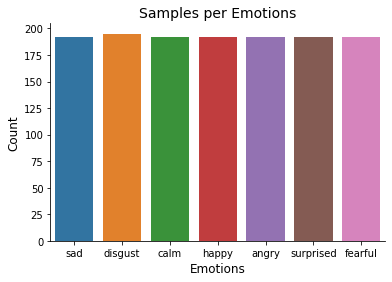

In [ ]:
plt.title('Samples per Emotions', size=14)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

**Extras**


*   Waveplots - Waveplots let us know the loudness of the audio at a given time.
*   Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.



In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

#emotion='fear'
#path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
#data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
#Audio(path)

#emotion='angry'
#path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
#data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
#Audio(path)

#emotion='sad'
#path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
#data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
#Audio(path)

#emotion='happy'
#path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
#data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
#Audio(path)

**Adding noise, stretch, shift, or pitch**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=data, sr=sample_rate)
#Audio(path)

#x = noise(data)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

#x = stretch(data)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

#x = shift(data)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

#x = pitch(data, sample_rate)
#plt.figure(figsize=(14,4))
#librosa.display.waveplot(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    # Zero Crossing Rate: Signal-change rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma standard Furrier transfer: represent the intensity of the twelve distinctive pitch classes
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Mel Frequency Cepstral Coefficients: from a spectral representation, freq bands distributed in mel-scale
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value for each frame of sample
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram: visualization of the freq spectrum of a signal, mel-scale mimics how the human ear works
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path): #first step of pre-processing
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.6, offset=0.4)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

len(X), len(Y), Ravdess_df.Path.shape

(4041, 4041, (1347,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
#extract features to csv
#Features.to_csv('features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.146205,0.667742,0.650311,0.605284,0.640242,0.584214,0.554824,0.560428,0.653882,0.703217,...,4.851268e-12,4.311642e-12,3.908758e-12,3.596597e-12,3.354412e-12,3.170622e-12,3.032781e-12,2.938114e-12,2.880097e-12,sad
1,0.238155,0.730797,0.709899,0.699673,0.743651,0.693966,0.637862,0.612920,0.663789,0.700250,...,3.954669e-05,4.042420e-05,4.215315e-05,3.988911e-05,4.014457e-05,3.983463e-05,4.147463e-05,4.153127e-05,3.999790e-05,sad
2,0.145794,0.622263,0.696846,0.669922,0.648794,0.670240,0.557148,0.536304,0.582282,0.706324,...,7.884864e-12,9.023218e-12,6.872001e-12,6.366100e-12,5.126208e-12,4.455651e-12,4.067148e-12,4.626031e-12,6.272078e-12,sad
3,0.131553,0.511452,0.517433,0.523196,0.569519,0.541172,0.582609,0.571208,0.617602,0.674876,...,1.027169e-13,9.975344e-14,9.628800e-14,9.274737e-14,8.946512e-14,8.669277e-14,8.446525e-14,8.280891e-14,8.180561e-14,disgust
4,0.216195,0.563484,0.567376,0.573103,0.608631,0.583587,0.582651,0.556596,0.606219,0.665101,...,2.394155e-06,2.641947e-06,2.609134e-06,2.466454e-06,2.674698e-06,2.676718e-06,2.779092e-06,2.692016e-06,2.681582e-06,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036,0.291840,0.589594,0.591000,0.655741,0.701490,0.650959,0.631581,0.622465,0.749211,0.839587,...,7.508753e-06,7.817934e-06,7.559982e-06,7.739756e-06,7.700972e-06,7.464576e-06,7.264522e-06,7.547160e-06,7.618376e-06,sad
4037,0.093481,0.468669,0.430125,0.426217,0.525552,0.577744,0.539737,0.577869,0.627450,0.773411,...,3.919815e-12,1.799201e-12,1.148143e-12,1.852405e-12,1.885976e-12,1.062264e-12,9.862020e-13,1.501526e-12,1.249907e-12,sad
4038,0.157022,0.601161,0.642363,0.591389,0.599222,0.567285,0.537874,0.562058,0.590552,0.649399,...,5.162014e-14,4.336369e-14,3.761053e-14,3.341838e-14,3.030565e-14,2.803135e-14,2.636821e-14,2.523700e-14,2.457089e-14,disgust
4039,0.249843,0.774179,0.815885,0.765511,0.784651,0.753496,0.667381,0.662019,0.692743,0.752164,...,1.761932e-06,1.698211e-06,1.719838e-06,1.746740e-06,1.815245e-06,1.782527e-06,1.909268e-06,1.949501e-06,1.885537e-06,disgust


**Second step of Pre-Processing**

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=6, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162), (3030, 7), (1011, 162), (1011, 7))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162), (3030, 7), (1011, 162), (1011, 7))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162, 1), (3030, 7), (1011, 162, 1), (1011, 7))

**Model deployment**

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(128))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 21, 128)         

**Loop**

In [ ]:
#model.save("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf", save_format='tf')

In [ ]:
eps=60
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=0.0000001)
mcp_save = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf', save_best_only=True, monitor='accuracy', 
                           mode='max', save_freq='epoch')

history=model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[rlrp, mcp_save])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 1.8956 - accuracy: 0.1875

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 65s 1s/step - loss: 1.8956 - accuracy: 0.1875 - val_loss: 1.8818 - val_accuracy: 0.2038 - lr: 0.0010
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 1.8406 - accuracy: 0.2221

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 684ms/step - loss: 1.8406 - accuracy: 0.2221 - val_loss: 1.8071 - val_accuracy: 0.2156 - lr: 0.0010
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 1.8073 - accuracy: 0.2383

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 682ms/step - loss: 1.8073 - accuracy: 0.2383 - val_loss: 1.7474 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 4/60
48/48 [==============================] - ETA: 0s - loss: 1.7643 - accuracy: 0.2673

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 692ms/step - loss: 1.7643 - accuracy: 0.2673 - val_loss: 1.7248 - val_accuracy: 0.2839 - lr: 0.0010
Epoch 5/60
48/48 [==============================] - ETA: 0s - loss: 1.7244 - accuracy: 0.2941

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 684ms/step - loss: 1.7244 - accuracy: 0.2941 - val_loss: 1.7077 - val_accuracy: 0.2938 - lr: 0.0010
Epoch 6/60
48/48 [==============================] - ETA: 0s - loss: 1.6684 - accuracy: 0.3152

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 684ms/step - loss: 1.6684 - accuracy: 0.3152 - val_loss: 1.6682 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 7/60
48/48 [==============================] - ETA: 0s - loss: 1.6205 - accuracy: 0.3373

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 35s 744ms/step - loss: 1.6205 - accuracy: 0.3373 - val_loss: 1.5503 - val_accuracy: 0.3759 - lr: 0.0010
Epoch 8/60
48/48 [==============================] - ETA: 0s - loss: 1.5802 - accuracy: 0.3657

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 655ms/step - loss: 1.5802 - accuracy: 0.3657 - val_loss: 1.5438 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 9/60
48/48 [==============================] - ETA: 0s - loss: 1.5477 - accuracy: 0.3848

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 688ms/step - loss: 1.5477 - accuracy: 0.3848 - val_loss: 1.4986 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 10/60
48/48 [==============================] - ETA: 0s - loss: 1.5246 - accuracy: 0.3908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 697ms/step - loss: 1.5246 - accuracy: 0.3908 - val_loss: 1.4553 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 11/60
48/48 [==============================] - ETA: 0s - loss: 1.4916 - accuracy: 0.3990

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 678ms/step - loss: 1.4916 - accuracy: 0.3990 - val_loss: 1.4474 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 12/60
48/48 [==============================] - ETA: 0s - loss: 1.4582 - accuracy: 0.4231

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 657ms/step - loss: 1.4582 - accuracy: 0.4231 - val_loss: 1.4614 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 13/60
48/48 [==============================] - ETA: 0s - loss: 1.4261 - accuracy: 0.4360

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 684ms/step - loss: 1.4261 - accuracy: 0.4360 - val_loss: 1.4538 - val_accuracy: 0.4204 - lr: 0.0010
Epoch 14/60
48/48 [==============================] - ETA: 0s - loss: 1.4165 - accuracy: 0.4508

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 673ms/step - loss: 1.4165 - accuracy: 0.4508 - val_loss: 1.4494 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 15/60
48/48 [==============================] - ETA: 0s - loss: 1.3601 - accuracy: 0.4630

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 672ms/step - loss: 1.3601 - accuracy: 0.4630 - val_loss: 1.4436 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 16/60
48/48 [==============================] - ETA: 0s - loss: 1.3481 - accuracy: 0.4723

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 687ms/step - loss: 1.3481 - accuracy: 0.4723 - val_loss: 1.3733 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 17/60
48/48 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.4908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 658ms/step - loss: 1.3085 - accuracy: 0.4908 - val_loss: 1.3489 - val_accuracy: 0.4827 - lr: 0.0010
Epoch 18/60
48/48 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.5050

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 34s 716ms/step - loss: 1.3009 - accuracy: 0.5050 - val_loss: 1.3395 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 19/60
48/48 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.5205

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 676ms/step - loss: 1.2467 - accuracy: 0.5205 - val_loss: 1.3326 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 20/60
48/48 [==============================] - ETA: 0s - loss: 1.2123 - accuracy: 0.5389

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 681ms/step - loss: 1.2123 - accuracy: 0.5389 - val_loss: 1.3207 - val_accuracy: 0.5064 - lr: 0.0010
Epoch 21/60
48/48 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.5597

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 644ms/step - loss: 1.1657 - accuracy: 0.5597 - val_loss: 1.3235 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 22/60
48/48 [==============================] - 22s 466ms/step - loss: 1.1507 - accuracy: 0.5548 - val_loss: 1.2865 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 23/60
48/48 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.5825

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 701ms/step - loss: 1.1045 - accuracy: 0.5825 - val_loss: 1.3702 - val_accuracy: 0.4916 - lr: 0.0010
Epoch 24/60
48/48 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.5990

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 661ms/step - loss: 1.0823 - accuracy: 0.5990 - val_loss: 1.3126 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 25/60
48/48 [==============================] - 21s 433ms/step - loss: 1.0893 - accuracy: 0.5891 - val_loss: 1.3078 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 26/60
48/48 [==============================] - ETA: 0s - loss: 1.0200 - accuracy: 0.6135

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 698ms/step - loss: 1.0200 - accuracy: 0.6135 - val_loss: 1.3021 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 27/60
48/48 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.6182

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 690ms/step - loss: 1.0144 - accuracy: 0.6182 - val_loss: 1.3291 - val_accuracy: 0.5134 - lr: 0.0010
Epoch 28/60
48/48 [==============================] - ETA: 0s - loss: 0.9547 - accuracy: 0.6452

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 690ms/step - loss: 0.9547 - accuracy: 0.6452 - val_loss: 1.2631 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 29/60
48/48 [==============================] - ETA: 0s - loss: 0.9047 - accuracy: 0.6690

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 686ms/step - loss: 0.9047 - accuracy: 0.6690 - val_loss: 1.2651 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 30/60
48/48 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.6752

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 35s 727ms/step - loss: 0.8879 - accuracy: 0.6752 - val_loss: 1.3547 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 31/60
48/48 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.6759

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 664ms/step - loss: 0.8846 - accuracy: 0.6759 - val_loss: 1.3037 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 32/60
48/48 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6950

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 687ms/step - loss: 0.8618 - accuracy: 0.6950 - val_loss: 1.2975 - val_accuracy: 0.5648 - lr: 0.0010
Epoch 33/60
48/48 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.6983

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 31s 662ms/step - loss: 0.8032 - accuracy: 0.6983 - val_loss: 1.3062 - val_accuracy: 0.5618 - lr: 0.0010
Epoch 34/60
48/48 [==============================] - 21s 432ms/step - loss: 0.8494 - accuracy: 0.6941 - val_loss: 1.2230 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 35/60
48/48 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.7208

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 695ms/step - loss: 0.7557 - accuracy: 0.7208 - val_loss: 1.1881 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 36/60
48/48 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7383

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 682ms/step - loss: 0.7324 - accuracy: 0.7383 - val_loss: 1.2929 - val_accuracy: 0.5529 - lr: 0.0010
Epoch 37/60
48/48 [==============================] - 20s 426ms/step - loss: 0.7549 - accuracy: 0.7264 - val_loss: 1.2638 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 38/60
48/48 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.7545

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 686ms/step - loss: 0.6806 - accuracy: 0.7545 - val_loss: 1.2157 - val_accuracy: 0.5915 - lr: 0.0010
Epoch 39/60
48/48 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7670

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 676ms/step - loss: 0.6396 - accuracy: 0.7670 - val_loss: 1.3284 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 40/60
48/48 [==============================] - 22s 449ms/step - loss: 0.6654 - accuracy: 0.7634 - val_loss: 1.3324 - val_accuracy: 0.5737 - lr: 0.0010
Epoch 41/60
48/48 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.7865

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 35s 736ms/step - loss: 0.5998 - accuracy: 0.7865 - val_loss: 1.3899 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 42/60
48/48 [==============================] - 21s 442ms/step - loss: 0.6282 - accuracy: 0.7815 - val_loss: 1.2594 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 43/60
48/48 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 697ms/step - loss: 0.5885 - accuracy: 0.7908 - val_loss: 1.3961 - val_accuracy: 0.5836 - lr: 0.0010
Epoch 44/60
48/48 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.8112

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 34s 719ms/step - loss: 0.5302 - accuracy: 0.8112 - val_loss: 1.3095 - val_accuracy: 0.6034 - lr: 0.0010
Epoch 45/60
48/48 [==============================] - 21s 447ms/step - loss: 0.5670 - accuracy: 0.8010 - val_loss: 1.4434 - val_accuracy: 0.5598 - lr: 0.0010
Epoch 46/60
48/48 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.8165

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 683ms/step - loss: 0.5374 - accuracy: 0.8165 - val_loss: 1.3056 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 47/60
48/48 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8363

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 697ms/step - loss: 0.4619 - accuracy: 0.8363 - val_loss: 1.4147 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 48/60
48/48 [==============================] - 21s 439ms/step - loss: 0.4739 - accuracy: 0.8356 - val_loss: 1.3817 - val_accuracy: 0.5836 - lr: 0.0010
Epoch 49/60
48/48 [==============================] - 21s 439ms/step - loss: 0.5105 - accuracy: 0.8185 - val_loss: 1.3887 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 50/60
48/48 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.8469

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 683ms/step - loss: 0.4275 - accuracy: 0.8469 - val_loss: 1.3975 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 51/60
48/48 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8604

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 698ms/step - loss: 0.4151 - accuracy: 0.8604 - val_loss: 1.4258 - val_accuracy: 0.5984 - lr: 0.0010
Epoch 52/60
48/48 [==============================] - 21s 438ms/step - loss: 0.4281 - accuracy: 0.8492 - val_loss: 1.4347 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 53/60
48/48 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8634

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 34s 714ms/step - loss: 0.3945 - accuracy: 0.8634 - val_loss: 1.4723 - val_accuracy: 0.5915 - lr: 0.0010
Epoch 54/60
48/48 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8723

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 666ms/step - loss: 0.3630 - accuracy: 0.8723 - val_loss: 1.5560 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 55/60
48/48 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8749

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 703ms/step - loss: 0.3727 - accuracy: 0.8749 - val_loss: 1.4085 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 56/60
48/48 [==============================] - 21s 434ms/step - loss: 0.3722 - accuracy: 0.8706 - val_loss: 1.4138 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 57/60
48/48 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8894

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 673ms/step - loss: 0.3262 - accuracy: 0.8894 - val_loss: 1.6010 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 58/60
48/48 [==============================] - 21s 434ms/step - loss: 0.3451 - accuracy: 0.8799 - val_loss: 1.4145 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 59/60
48/48 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8983

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 703ms/step - loss: 0.2940 - accuracy: 0.8983 - val_loss: 1.5234 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 60/60
48/48 [==============================] - 21s 435ms/step - loss: 0.2888 - accuracy: 0.8970 - val_loss: 1.5743 - val_accuracy: 0.5945 - lr: 0.0010


32/32 [==============================] - 2s 48ms/step - loss: 1.5743 - accuracy: 0.5945
Accuracy of our model on test data :  59.44609045982361 %


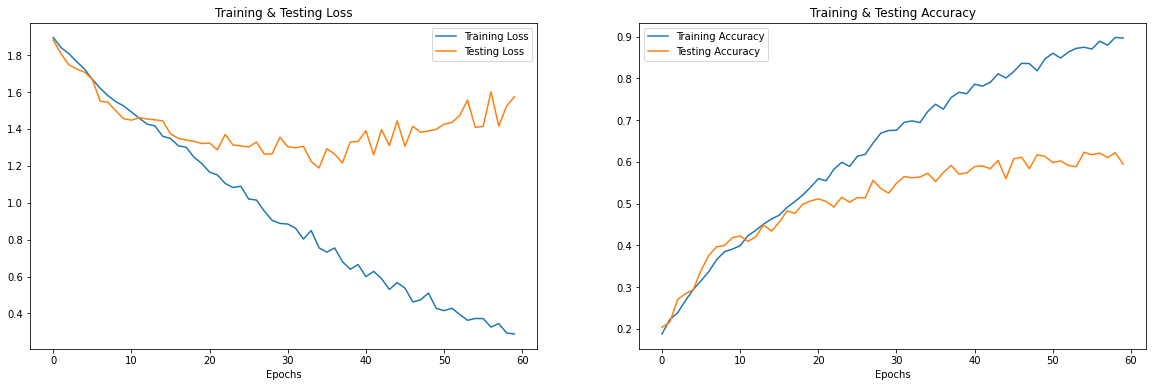

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(eps)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
history = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf")

earlyStopping = EarlyStopping(monitor='accuracy', patience=6, verbose=0, mode='max')
mcp_save_2 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf', save_best_only=True, monitor='accuracy', 
                           mode='max', save_freq='epoch')
inc_accuracy = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=6, verbose=0, mode='max')

history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping, mcp_save_2, inc_accuracy])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8809

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 684ms/step - loss: 0.3456 - accuracy: 0.8809 - val_loss: 1.4384 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9036

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 688ms/step - loss: 0.2839 - accuracy: 0.9036 - val_loss: 1.5527 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9155

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 35s 729ms/step - loss: 0.2640 - accuracy: 0.9155 - val_loss: 1.6280 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 4/60
48/48 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9191

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 694ms/step - loss: 0.2396 - accuracy: 0.9191 - val_loss: 1.6346 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 5/60
48/48 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9218

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 693ms/step - loss: 0.2446 - accuracy: 0.9218 - val_loss: 1.5335 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 6/60
48/48 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9264

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 691ms/step - loss: 0.2200 - accuracy: 0.9264 - val_loss: 1.6910 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 7/60
48/48 [==============================] - 21s 432ms/step - loss: 0.2247 - accuracy: 0.9251 - val_loss: 1.6218 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 8/60
48/48 [==============================] - 21s 433ms/step - loss: 0.2535 - accuracy: 0.9182 - val_loss: 1.6822 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 9/60
48/48 [==============================] - 21s 431ms/step - loss: 0.2784 - accuracy: 0.9053 - val_loss: 1.5279 - val_accuracy: 0.6489 - lr: 0.0010
Epoch 10/60
48/48 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9419

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 678ms/step - loss: 0.1819 - accuracy: 0.9419 - val_loss: 1.7530 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 11/60
48/48 [==============================] - 21s 433ms/step - loss: 0.2870 - accuracy: 0.9010 - val_loss: 1.5749 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 12/60
48/48 [==============================] - 21s 437ms/step - loss: 0.2404 - accuracy: 0.9195 - val_loss: 1.6702 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 13/60
48/48 [==============================] - 20s 425ms/step - loss: 0.1942 - accuracy: 0.9363 - val_loss: 1.5774 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 14/60
48/48 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9442

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 676ms/step - loss: 0.1692 - accuracy: 0.9442 - val_loss: 1.6712 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 15/60
48/48 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9479

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 680ms/step - loss: 0.1525 - accuracy: 0.9479 - val_loss: 1.8091 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 16/60
48/48 [==============================] - 23s 471ms/step - loss: 0.2018 - accuracy: 0.9370 - val_loss: 1.7416 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 17/60
48/48 [==============================] - 21s 438ms/step - loss: 0.1940 - accuracy: 0.9413 - val_loss: 1.6699 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 18/60
48/48 [==============================] - 21s 431ms/step - loss: 0.1797 - accuracy: 0.9393 - val_loss: 1.6962 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 19/60
48/48 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9525

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 696ms/step - loss: 0.1403 - accuracy: 0.9525 - val_loss: 1.8152 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 20/60
48/48 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9528

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 686ms/step - loss: 0.1544 - accuracy: 0.9528 - val_loss: 1.7834 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 21/60
48/48 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9581

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 670ms/step - loss: 0.1251 - accuracy: 0.9581 - val_loss: 1.8932 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 22/60
48/48 [==============================] - 21s 433ms/step - loss: 0.2821 - accuracy: 0.9033 - val_loss: 1.5742 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 23/60
48/48 [==============================] - 21s 442ms/step - loss: 0.1709 - accuracy: 0.9403 - val_loss: 1.6513 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 24/60
48/48 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9584

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 693ms/step - loss: 0.1129 - accuracy: 0.9584 - val_loss: 1.6807 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 25/60
48/48 [==============================] - 21s 433ms/step - loss: 0.1452 - accuracy: 0.9551 - val_loss: 1.9120 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 26/60
48/48 [==============================] - 21s 440ms/step - loss: 0.1821 - accuracy: 0.9403 - val_loss: 1.6714 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 27/60
48/48 [==============================] - 21s 440ms/step - loss: 0.1473 - accuracy: 0.9492 - val_loss: 1.7456 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 28/60
48/48 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9601

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 685ms/step - loss: 0.1217 - accuracy: 0.9601 - val_loss: 1.8202 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 29/60
48/48 [==============================] - 22s 467ms/step - loss: 0.1612 - accuracy: 0.9498 - val_loss: 1.8915 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 30/60
48/48 [==============================] - 21s 441ms/step - loss: 0.1628 - accuracy: 0.9525 - val_loss: 1.7452 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 31/60
48/48 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9637

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 692ms/step - loss: 0.1123 - accuracy: 0.9637 - val_loss: 1.8975 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 32/60
48/48 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9726

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 695ms/step - loss: 0.0965 - accuracy: 0.9726 - val_loss: 2.0224 - val_accuracy: 0.6508 - lr: 0.0010
Epoch 33/60
48/48 [==============================] - 21s 434ms/step - loss: 0.1398 - accuracy: 0.9561 - val_loss: 2.0033 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 34/60
48/48 [==============================] - 21s 433ms/step - loss: 0.1885 - accuracy: 0.9363 - val_loss: 1.8557 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 35/60
48/48 [==============================] - 21s 439ms/step - loss: 0.1125 - accuracy: 0.9670 - val_loss: 1.9044 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 36/60
48/48 [==============================] - 21s 436ms/step - loss: 0.1306 - accuracy: 0.9561 - val_loss: 1.9466 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 37/60
48/48 [==============================] - 21s 440ms/step - loss: 0.1534 - accuracy: 0.9561 - val_loss: 1.7030 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 38/60
48/48 [==============================] - 21s 437ms/step - 

In [ ]:
history = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf")

earlyStopping_1 = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='min')
mcp_save_3 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf', save_best_only=True, monitor='val_loss', 
                           mode='min', save_freq='epoch')
reduce_val_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=0, mode='min')

history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping_1, mcp_save_3, reduce_val_loss])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9802

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 699ms/step - loss: 0.0702 - accuracy: 0.9802 - val_loss: 1.8939 - val_accuracy: 0.6320 - lr: 1.0000e-04
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 680ms/step - loss: 0.0409 - accuracy: 0.9908 - val_loss: 1.8596 - val_accuracy: 0.6479 - lr: 1.0000e-04
Epoch 3/60
48/48 [==============================] - 21s 433ms/step - loss: 0.0314 - accuracy: 0.9917 - val_loss: 1.8679 - val_accuracy: 0.6469 - lr: 1.0000e-04
Epoch 4/60
48/48 [==============================] - 22s 461ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 1.8652 - val_accuracy: 0.6508 - lr: 1.0000e-04
Epoch 5/60
48/48 [==============================] - 21s 439ms/step - loss: 0.0304 - accuracy: 0.9917 - val_loss: 1.8783 - val_accuracy: 0.6528 - lr: 1.0000e-04
Epoch 6/60
48/48 [==============================] - 21s 436ms/step - loss: 0.0219 - accuracy: 0.9964 - val_loss: 1.8985 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 7/60
48/48 [==============================] - 21s 435ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 1.9007 - val_accuracy: 0.6657 - lr: 1.0000e-04
Epoch 8/60
48/48 [==============================] -

In [ ]:
earlyStopping_2 = EarlyStopping(monitor='val_accuracy', patience=6, verbose=0, mode='max')
mcp_save_4 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf', save_best_only=True, monitor='val_accuracy', 
                           mode='max', save_freq='epoch')
increase_val_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, verbose=0, mode='max')
history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping_2, mcp_save_4, increase_val_acc])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9977

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 34s 711ms/step - loss: 0.0144 - accuracy: 0.9977 - val_loss: 1.9178 - val_accuracy: 0.6597 - lr: 1.0000e-05
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9957

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 33s 685ms/step - loss: 0.0206 - accuracy: 0.9957 - val_loss: 1.9193 - val_accuracy: 0.6607 - lr: 1.0000e-05
Epoch 3/60
48/48 [==============================] - 20s 428ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 1.9230 - val_accuracy: 0.6597 - lr: 1.0000e-05
Epoch 4/60
48/48 [==============================] - 21s 429ms/step - loss: 0.0187 - accuracy: 0.9957 - val_loss: 1.9249 - val_accuracy: 0.6607 - lr: 1.0000e-05
Epoch 5/60
48/48 [==============================] - 20s 421ms/step - loss: 0.0184 - accuracy: 0.9950 - val_loss: 1.9267 - val_accuracy: 0.6607 - lr: 1.0000e-05
Epoch 6/60
48/48 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9970

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 679ms/step - loss: 0.0155 - accuracy: 0.9970 - val_loss: 1.9277 - val_accuracy: 0.6627 - lr: 1.0000e-05
Epoch 7/60
48/48 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9964

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_wo_kfold_1moreConv.tf/assets


48/48 [==============================] - 32s 680ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 1.9292 - val_accuracy: 0.6637 - lr: 1.0000e-05
Epoch 8/60
48/48 [==============================] - 21s 429ms/step - loss: 0.0171 - accuracy: 0.9964 - val_loss: 1.9295 - val_accuracy: 0.6597 - lr: 1.0000e-05
Epoch 9/60
48/48 [==============================] - 20s 426ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 1.9317 - val_accuracy: 0.6607 - lr: 1.0000e-05
Epoch 10/60
48/48 [==============================] - 22s 466ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 1.9337 - val_accuracy: 0.6597 - lr: 1.0000e-05
Epoch 11/60
48/48 [==============================] - 21s 428ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 1.9348 - val_accuracy: 0.6627 - lr: 1.0000e-05
Epoch 12/60
48/48 [==============================] - 21s 431ms/step - loss: 0.0142 - accuracy: 0.9983 - val_loss: 1.9384 - val_accuracy: 0.6617 - lr: 1.0000e-05
Epoch 13/60
48/48 [=============================

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_ = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_.flatten()

df

,Predicted Labels,Actual Labels
0,angry,disgust
1,surprised,angry
2,sad,sad
3,sad,sad
4,calm,calm
...,...,...
1006,disgust,disgust
1007,calm,calm
1008,fearful,fearful
1009,disgust,angry


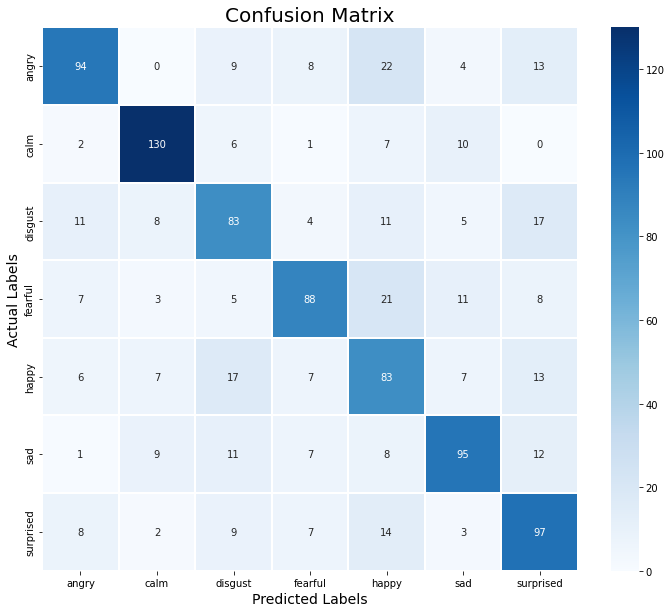

In [ ]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.63      0.67       150
        calm       0.82      0.83      0.83       156
     disgust       0.59      0.60      0.59       139
     fearful       0.72      0.62      0.66       143
       happy       0.50      0.59      0.54       140
         sad       0.70      0.66      0.68       143
   surprised       0.61      0.69      0.65       140

    accuracy                           0.66      1011
   macro avg       0.67      0.66      0.66      1011
weighted avg       0.67      0.66      0.66      1011



In [ ]:
#loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model.tf")
#loaded_model = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[rlrp])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 21, 128)         